<a href="https://colab.research.google.com/github/junyizhou0304/LLM-NLP-CV-Projects/blob/main/EAI6010_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset chosen: MNIST database
https://en.wikipedia.org/wiki/MNIST_database

Model chosen: resnet18(weights="IMAGENET1K_V1")

In [ ]:
# 1.Setup & Imports
!pip install torch torchvision torchaudio -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models

import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if device.type == "cuda":
    torch.cuda.manual_seed_all(seed)


Using device: cuda


In [ ]:
# 2.Transforms & Datasets (MNIST → 224×224, 3-channel)
# ImageNet normalization (for ResNet18)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

# Base transform (no augmentation)
base_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Augmented transform (for regularization experiment)
aug_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Full train set with base transform
full_train_base = datasets.MNIST(
    root="./data", train=True, download=True, transform=base_transform
)

# Full train set with augmentation (same images, different transform)
full_train_aug = datasets.MNIST(
    root="./data", train=True, download=True, transform=aug_transform
)

# Test set (no augmentation)
test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=base_transform
)

len(full_train_base), len(test_dataset)


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.76MB/s]


(60000, 10000)

In [ ]:
# 3.Create Train/Validation Splits & Loaders
from torch.utils.data import random_split

num_train = len(full_train_base)
indices = torch.randperm(num_train)

# 50k train / 10k validation
train_size = 50000
val_size = num_train - train_size

train_idx = indices[:train_size]
val_idx = indices[train_size:]

# Subsets for baseline (no aug) and augmented training
train_dataset_base = Subset(full_train_base, train_idx)
train_dataset_aug = Subset(full_train_aug, train_idx)
val_dataset = Subset(full_train_base, val_idx)  # validation never augmented

# Small subset (10k) for deliberate overfitting
small_train_size = 10000
small_train_idx = train_idx[:small_train_size]
small_train_dataset = Subset(full_train_base, small_train_idx)

# DataLoaders
batch_size = 128

overfit_train_loader = DataLoader(small_train_dataset, batch_size=batch_size, shuffle=True)
train_loader_base    = DataLoader(train_dataset_base, batch_size=batch_size, shuffle=True)
train_loader_aug     = DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True)
val_loader           = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader          = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

len(small_train_dataset), len(train_dataset_base), len(val_dataset), len(test_dataset)


(10000, 50000, 10000, 10000)

In [ ]:
# 4.Model Helper & Training Utilities
# 4.1 Create ResNet18 for MNIST
def create_resnet18(num_classes=10):
    # You may need to adjust this depending on PyTorch version
    try:
        weights = models.ResNet18_Weights.IMAGENET1K_V1
        model = models.resnet18(weights=weights)
    except AttributeError:
        # Fallback for older versions
        model = models.resnet18(pretrained=True)

    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model.to(device)


In [ ]:
# 4.2 Train / Eval Functions
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [ ]:
# 4.3 Generic Training Loop (with optional early stopping)
def run_training(
    experiment_name,
    train_loader,
    val_loader,
    num_epochs=30,
    lr=1e-3,
    weight_decay=0.0,
    patience=None  # None = no early stopping
):
    print(f"\n=== Experiment: {experiment_name} ===")
    model = create_resnet18(num_classes=10)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    best_val_loss = float("inf")
    best_state_dict = None
    epochs_no_improve = 0

    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = evaluate(model, val_loader, criterion)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(
            f"Epoch [{epoch:02d}/{num_epochs:02d}] "
            f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}"
        )

        # Track best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state_dict = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Early stopping
        if patience is not None and epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch}.")
            break

    # Load best weights
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)

    return model, history


In [ ]:
# 4.4 Plotting
def plot_history(history, title="Training History"):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title + " - Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(title + " - Accuracy")
    plt.legend()

    plt.show()



=== Experiment: Overfit_SmallTrain_NoReg ===
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 196MB/s]


Epoch [01/50] Train Loss: 0.1369 Acc: 0.9583 | Val Loss: 0.0721 Acc: 0.9791
Epoch [02/50] Train Loss: 0.0379 Acc: 0.9882 | Val Loss: 0.0661 Acc: 0.9804
Epoch [03/50] Train Loss: 0.0366 Acc: 0.9880 | Val Loss: 0.0604 Acc: 0.9823
Epoch [04/50] Train Loss: 0.0315 Acc: 0.9901 | Val Loss: 0.0765 Acc: 0.9764
Epoch [05/50] Train Loss: 0.0192 Acc: 0.9948 | Val Loss: 0.0312 Acc: 0.9912
Epoch [06/50] Train Loss: 0.0152 Acc: 0.9952 | Val Loss: 0.1033 Acc: 0.9684
Epoch [07/50] Train Loss: 0.0162 Acc: 0.9942 | Val Loss: 0.0491 Acc: 0.9855
Epoch [08/50] Train Loss: 0.0103 Acc: 0.9968 | Val Loss: 0.0340 Acc: 0.9887
Epoch [09/50] Train Loss: 0.0079 Acc: 0.9973 | Val Loss: 0.0278 Acc: 0.9923
Epoch [10/50] Train Loss: 0.0039 Acc: 0.9990 | Val Loss: 0.0300 Acc: 0.9916
Epoch [11/50] Train Loss: 0.0029 Acc: 0.9993 | Val Loss: 0.0394 Acc: 0.9907
Epoch [12/50] Train Loss: 0.0056 Acc: 0.9978 | Val Loss: 0.0650 Acc: 0.9822
Epoch [13/50] Train Loss: 0.0050 Acc: 0.9986 | Val Loss: 0.0443 Acc: 0.9893
Epoch [14/50

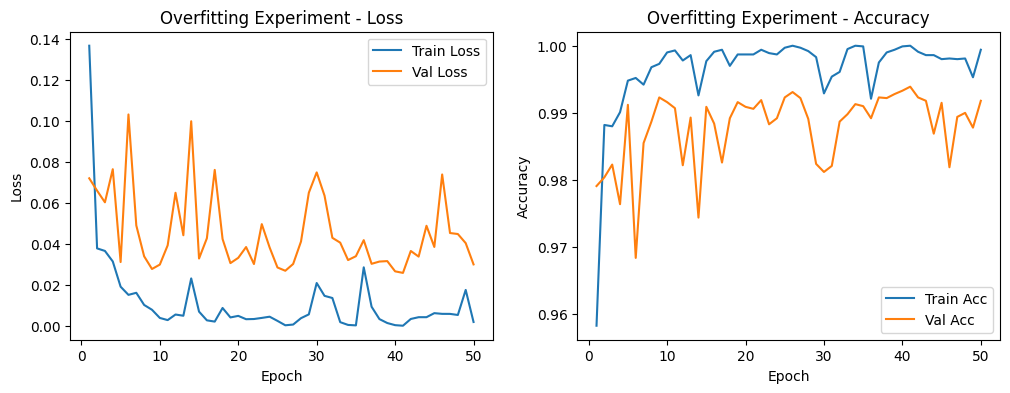

In [ ]:
# 5.Phase A – Deliberate Overfitting (Small Train Set, No Regularization)
overfit_model, overfit_history = run_training(
    experiment_name="Overfit_SmallTrain_NoReg",
    train_loader=overfit_train_loader,
    val_loader=val_loader,
    num_epochs=50,      # long training to force overfitting
    lr=1e-3,
    weight_decay=0.0,   # no regularization
    patience=None       # no early stopping
)

plot_history(overfit_history, title="Overfitting Experiment")



=== Experiment: Baseline_FullTrain_LightReg ===
Epoch [01/30] Train Loss: 0.0652 Acc: 0.9796 | Val Loss: 0.0584 Acc: 0.9820
Epoch [02/30] Train Loss: 0.0288 Acc: 0.9912 | Val Loss: 0.0430 Acc: 0.9867
Epoch [03/30] Train Loss: 0.0252 Acc: 0.9923 | Val Loss: 0.0222 Acc: 0.9935
Epoch [04/30] Train Loss: 0.0179 Acc: 0.9947 | Val Loss: 0.1193 Acc: 0.9712
Epoch [05/30] Train Loss: 0.0192 Acc: 0.9941 | Val Loss: 0.0320 Acc: 0.9903
Epoch [06/30] Train Loss: 0.0164 Acc: 0.9947 | Val Loss: 0.0295 Acc: 0.9911
Epoch [07/30] Train Loss: 0.0137 Acc: 0.9955 | Val Loss: 0.0223 Acc: 0.9939
Epoch [08/30] Train Loss: 0.0163 Acc: 0.9952 | Val Loss: 0.0234 Acc: 0.9926
Epoch [09/30] Train Loss: 0.0127 Acc: 0.9962 | Val Loss: 0.0307 Acc: 0.9915
Epoch [10/30] Train Loss: 0.0129 Acc: 0.9958 | Val Loss: 0.0243 Acc: 0.9930
Epoch [11/30] Train Loss: 0.0129 Acc: 0.9959 | Val Loss: 0.0201 Acc: 0.9937
Epoch [12/30] Train Loss: 0.0117 Acc: 0.9964 | Val Loss: 0.0267 Acc: 0.9921
Epoch [13/30] Train Loss: 0.0109 Acc: 0

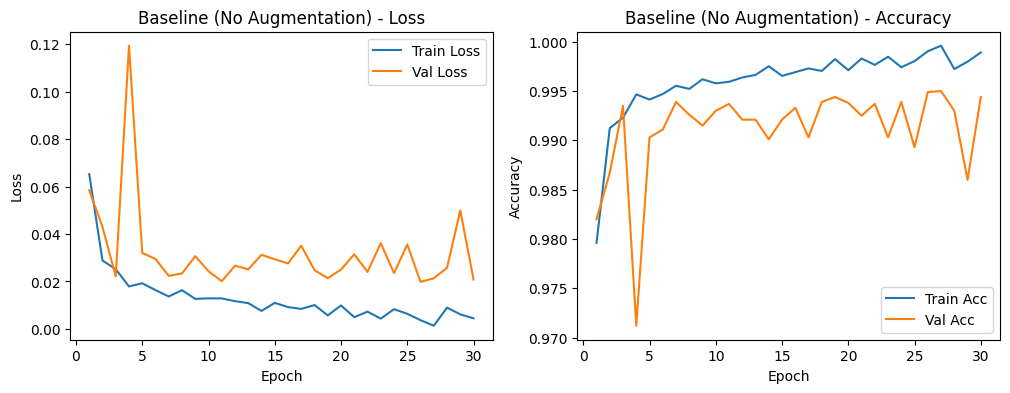

In [ ]:
# 6. Phase B – Preventing Overtraining
# 6.1 Baseline (Full Train, Light Regularization, No Augmentation)
# baseline_model, baseline_history = run_training(
baseline_model, baseline_history = run_training(
    experiment_name="Baseline_FullTrain_LightReg",
    train_loader=train_loader_base,
    val_loader=val_loader,
    num_epochs=30,
    lr=1e-3,
    weight_decay=1e-5,  # light L2
    patience=None
)

plot_history(baseline_history, title="Baseline (No Augmentation)")




=== Experiment: Aug_StrongerReg_EarlyStop ===
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s]


Epoch [01/50] Train Loss: 0.0820 Acc: 0.9760 | Val Loss: 0.0419 Acc: 0.9875
Epoch [02/50] Train Loss: 0.0463 Acc: 0.9860 | Val Loss: 0.0665 Acc: 0.9790
Epoch [03/50] Train Loss: 0.0475 Acc: 0.9855 | Val Loss: 0.0364 Acc: 0.9890
Epoch [04/50] Train Loss: 0.0421 Acc: 0.9875 | Val Loss: 0.0289 Acc: 0.9914
Epoch [05/50] Train Loss: 0.0414 Acc: 0.9878 | Val Loss: 0.0361 Acc: 0.9890
Epoch [06/50] Train Loss: 0.0409 Acc: 0.9877 | Val Loss: 0.0281 Acc: 0.9919
Epoch [07/50] Train Loss: 0.0394 Acc: 0.9882 | Val Loss: 0.0387 Acc: 0.9881
Epoch [08/50] Train Loss: 0.0335 Acc: 0.9900 | Val Loss: 0.0351 Acc: 0.9898
Epoch [09/50] Train Loss: 0.0328 Acc: 0.9902 | Val Loss: 0.0246 Acc: 0.9929
Epoch [10/50] Train Loss: 0.0319 Acc: 0.9904 | Val Loss: 0.0306 Acc: 0.9904
Epoch [11/50] Train Loss: 0.0324 Acc: 0.9905 | Val Loss: 0.0344 Acc: 0.9897
Epoch [12/50] Train Loss: 0.0282 Acc: 0.9916 | Val Loss: 0.0258 Acc: 0.9918
Epoch [13/50] Train Loss: 0.0309 Acc: 0.9909 | Val Loss: 0.0269 Acc: 0.9922
Epoch [14/50

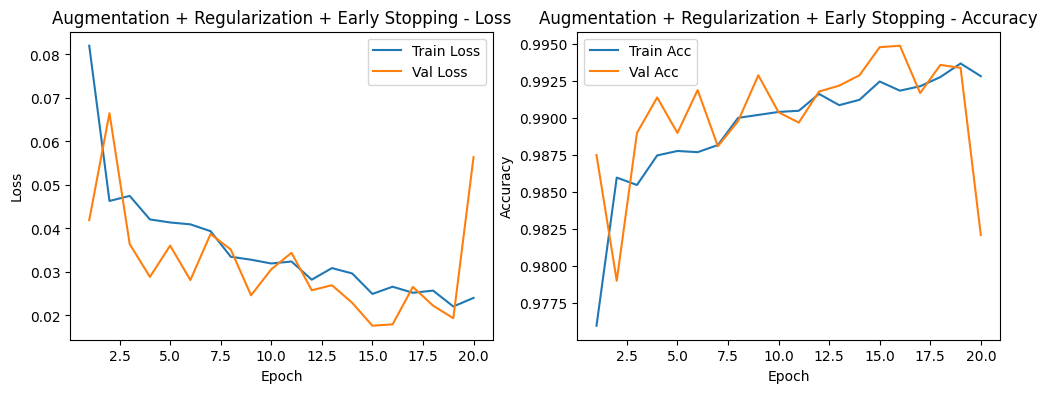

In [ ]:
# 6.2 Augmentation + Stronger Regularization + Early Stopping
reg_model, reg_history = run_training(
    experiment_name="Aug_StrongerReg_EarlyStop",
    train_loader=train_loader_aug,
    val_loader=val_loader,
    num_epochs=50,
    lr=1e-3,
    weight_decay=1e-4,   # stronger L2
    patience=5           # early stopping on validation loss
)

plot_history(reg_history, title="Augmentation + Regularization + Early Stopping")


In [ ]:
# Evaluate Best Model on Test Set & Class-wise Performance
def evaluate_on_test(model, loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, digits=4)

    print("Classification Report:\n", report)
    return cm, report

cm, report = evaluate_on_test(reg_model, test_loader)


Classification Report:
               precision    recall  f1-score   support

           0     0.9969    0.9908    0.9939       980
           1     0.9775    0.9956    0.9865      1135
           2     0.9960    0.9545    0.9748      1032
           3     0.9815    0.9960    0.9887      1010
           4     0.9909    0.9959    0.9934       982
           5     0.9612    0.9989    0.9797       892
           6     0.9968    0.9729    0.9847       958
           7     0.9625    0.9981    0.9799      1028
           8     0.9989    0.9620    0.9801       974
           9     0.9900    0.9841    0.9871      1009

    accuracy                         0.9849     10000
   macro avg     0.9852    0.9849    0.9849     10000
weighted avg     0.9852    0.9849    0.9849     10000



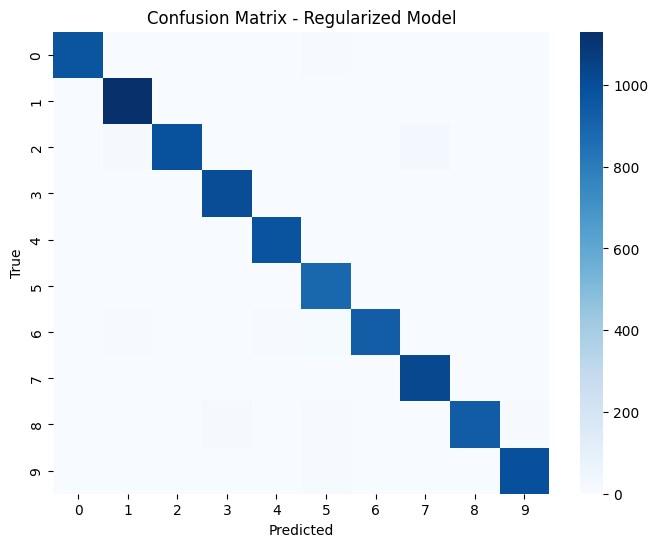

In [ ]:
# Visualize Confusion Matrix
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Regularized Model")
plt.show()
